In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import scienceplots as scp

import numpy as np
import torch

matplotlib.rcParams['figure.figsize'] = (20, 6)

from main import main, parse_args

from argparse import Namespace
from utils.plotting import plot_change_responses, plot_trial_responses, plot_omission_responses, plot_sequence_response
from utils.analysis import process_outputs, get_change_responses, get_omission_responses

import os

SCRATCH = "/storage/scratch1/2/asharafeldin3"

In [33]:
import importlib 
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_change_responses, plot_trial_responses, plot_omission_responses, plot_sequence_response

In [3]:
def load_results_files(directory, prefix):
    # Ensure directory exists
    if not os.path.isdir(directory):
        print(f"Error: {directory} is not a valid directory.")
        return {}

    # Get list of files in directory
    files = os.listdir(directory)
    # Filter files by prefix and ending with '.pt'
    torch_files = [file for file in files if file.startswith(prefix)]

    args = None

    change_responses = {"familiar": {}, "novel": {}}
    omission_responses = {"familiar": {}, "novel": {}}
    for i, file in enumerate(torch_files):
        file_path = os.path.join(directory, file)
        try:
            # Load Torch file
            data = torch.load(file_path, map_location='cpu')
            # Concatenate tensors along the first axis

            if args is None:
                args = data['args']

            # first for change responses
            for key in data["change_responses"]["familiar"].keys():
                fam_value = data["change_responses"]["familiar"][key]
                nov_value = data["change_responses"]["novel"][key]
                if key not in change_responses["familiar"]:
                    change_responses["familiar"][key] = fam_value
                    change_responses["novel"][key] = nov_value
                else:
                    change_responses["familiar"][key] = torch.cat([change_responses["familiar"][key], fam_value])
                    change_responses["novel"][key] = torch.cat([change_responses["novel"][key], nov_value])
            
            # now for omission responses
            for key in data["omission_responses"]["familiar"].keys():
                fam_value = data["omission_responses"]["familiar"][key]
                nov_value = data["omission_responses"]["novel"][key]
                if key not in omission_responses["familiar"]:
                    omission_responses["familiar"][key] = fam_value
                    omission_responses["novel"][key] = nov_value
                else:
                    omission_responses["familiar"][key] = torch.cat([omission_responses["familiar"][key], fam_value])
                    omission_responses["novel"][key] = torch.cat([omission_responses["novel"][key], nov_value])

            print(f"Loaded {i + 1}/{len(torch_files)} files", end='\r')
        except Exception as e:
            print(f"Error loading {file}: {str(e)}")
    return args, change_responses, omission_responses

#### Perception only

In [35]:
args, change_responses, omission_responses = load_results_files(f"{SCRATCH}/novelty_encoding_model/results/perception_only", "perception_only")
args = Namespace(**args)

/scratch/2031461/ipykernel_57570/1890722279.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path, map_location='cpu')


/storage/home/hcoda1/2/asharafeldin3/code/cortical_circuit_model_for_novelty_encoding/utils/plotting.py:39: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(half_blank, half_blank + args.img_ts, color=pre_clr, alpha=0.25, edgecolor="none", linewidth=0, zorder=1)
/storage/home/hcoda1/2/asharafeldin3/code/cortical_circuit_model_for_novelty_encoding/utils/plotting.py:40: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(half_blank + args.blank_ts + args.img_ts, half_blank + args.blank_ts + 2 * args.img_ts, color=change_clr, alpha=0.25,


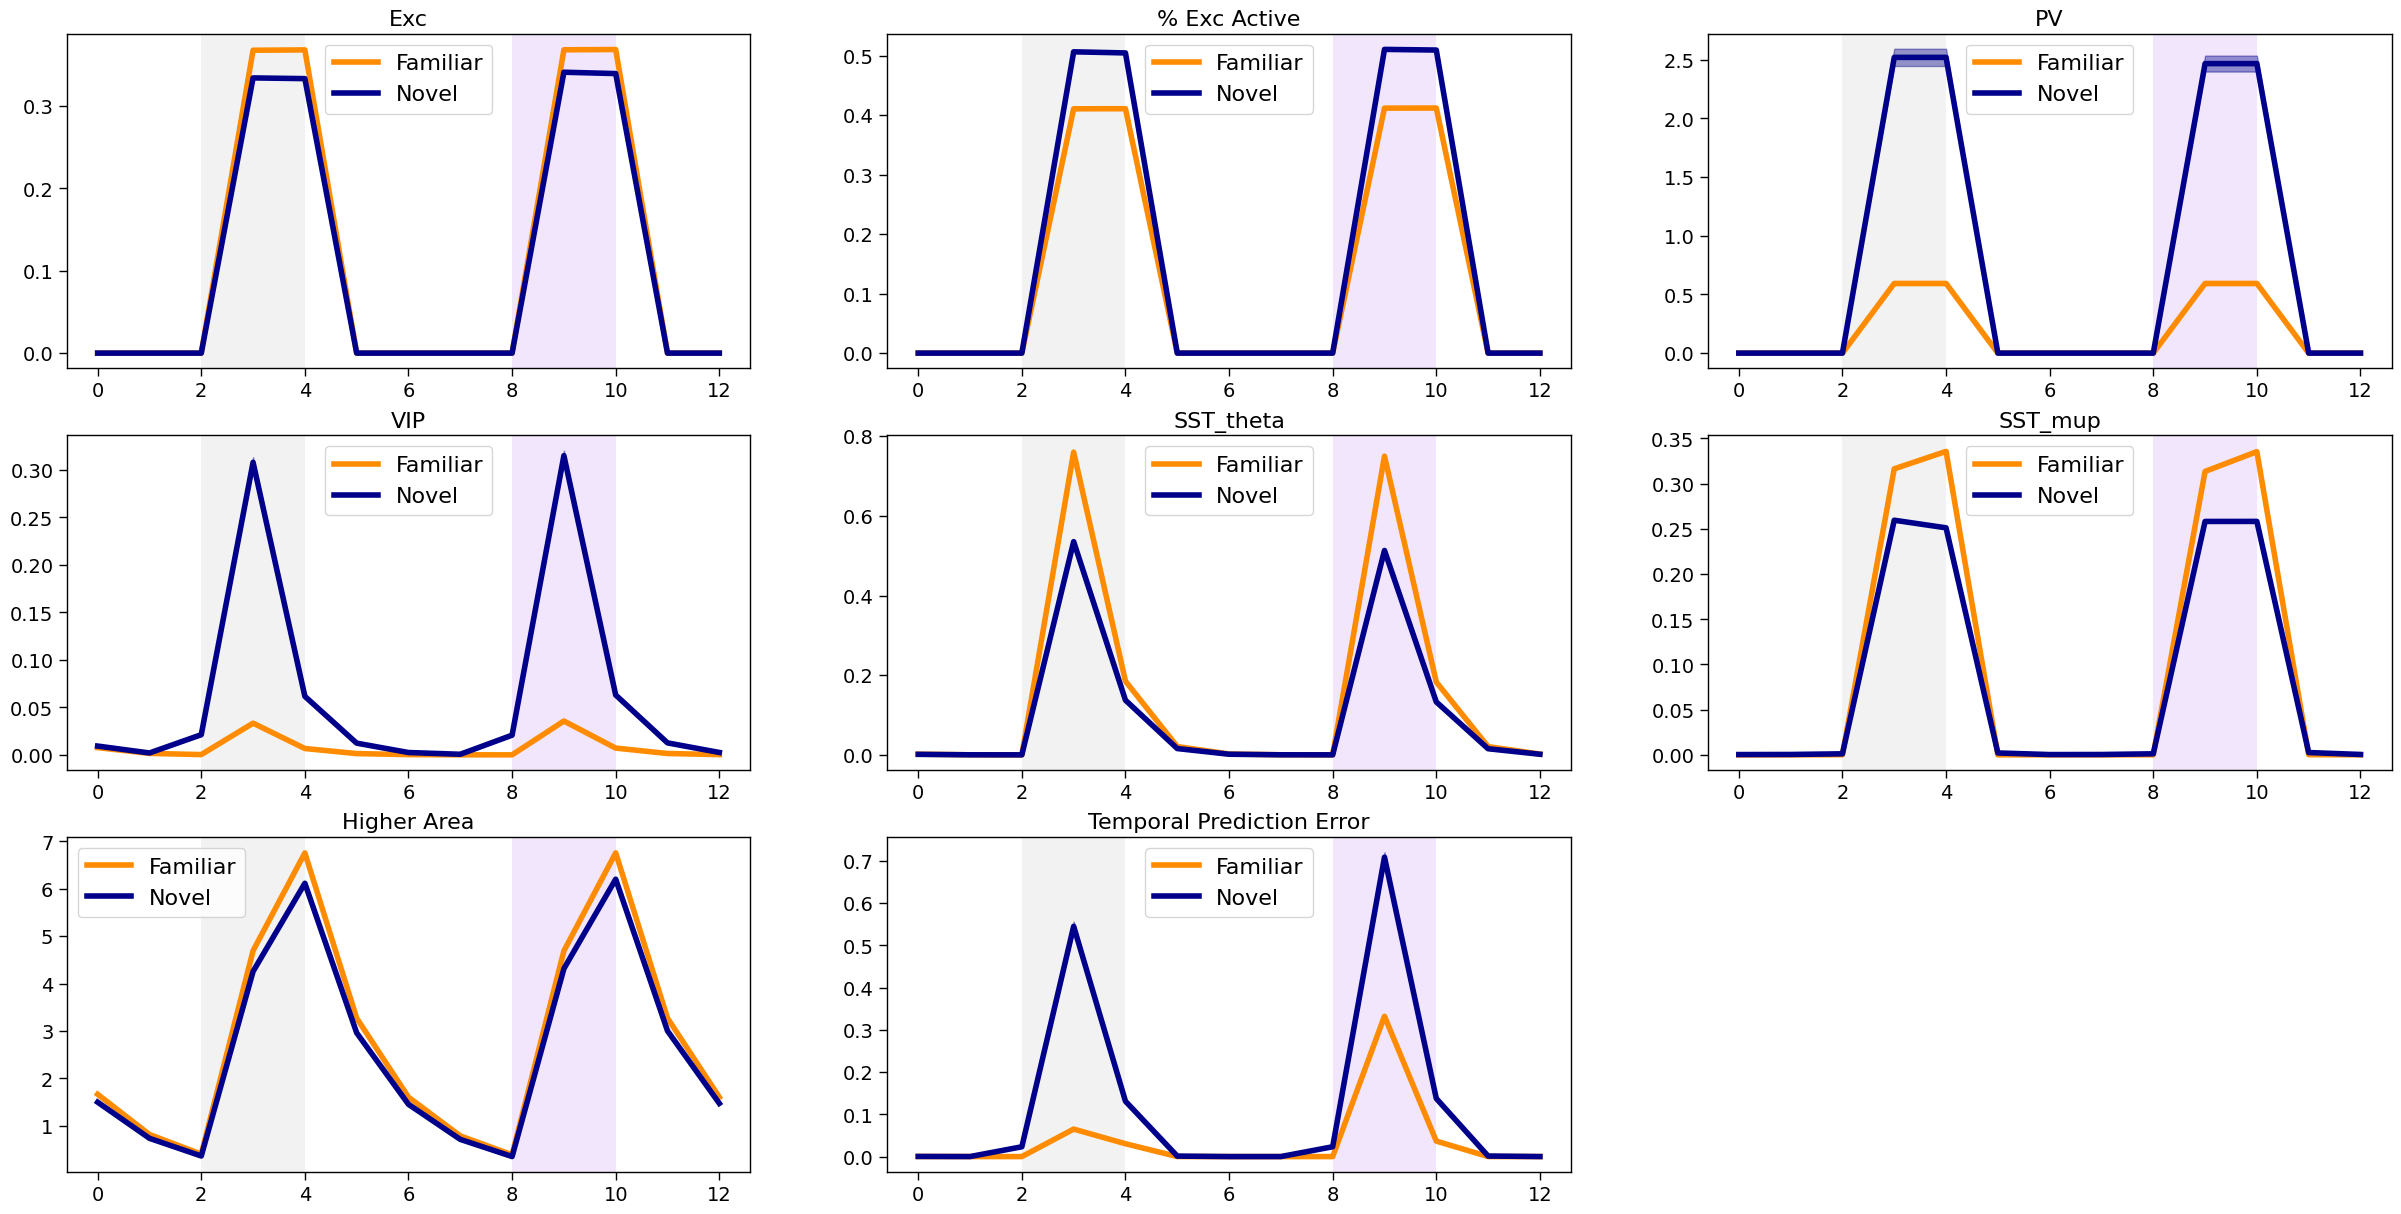

In [36]:
##### plot responses around image change

debug = False

include_pops = {'z': 'Exc', 'frac_active': '% Exc Active', 'sigma_q': 'PV', 'sigma_p': 'VIP',
                'theta': 'SST_theta', 'mu_p': 'SST_mup', 'h': 'Higher Area', 'temp_error': 'Temporal Prediction Error'}

crf = change_responses['familiar']
crn = change_responses['novel']

nonlin = lambda x: 0.1 * torch.exp(-100. * x)#torch.relu(torch.tanh(10 * (x + 2.))) #torch.relu(torch.tanh((x + 0.05)))  #torch.relu(torch.tanh(1 * (x + 0.2)))

change_responses['familiar']['exp'] = torch.exp(crf['sigmap_h'])
change_responses['novel']['exp'] = torch.exp(crn['sigmap_h'])

with plt.style.context(['nature', 'notebook']):
    
    if debug:
        
        fig3 = plt.figure(figsize=(40, 20))
        plt.tight_layout(pad=10, h_pad=5)
        
        for i, pop in enumerate(change_responses['familiar'].keys()):
            ax = plt.subplot(6, 3, i+1)
            plot_trial_responses(args, ax, change_responses['familiar'][pop], change_responses['novel'][pop], normalize=False)
            ax.set_title(f"{pop}")
            ax.legend()
    else:
        
        fig3 = plt.figure(figsize=(30, 20))
        plt.tight_layout(pad=10, h_pad=5)
        
        for i, pop in enumerate(include_pops.keys()):
            ax = plt.subplot(4, 3, i+1)
            plot_trial_responses(args, ax, change_responses['familiar'][pop], change_responses['novel'][pop], normalize=False)
            ax.set_title(f"{include_pops[pop]}")
            ax.legend()

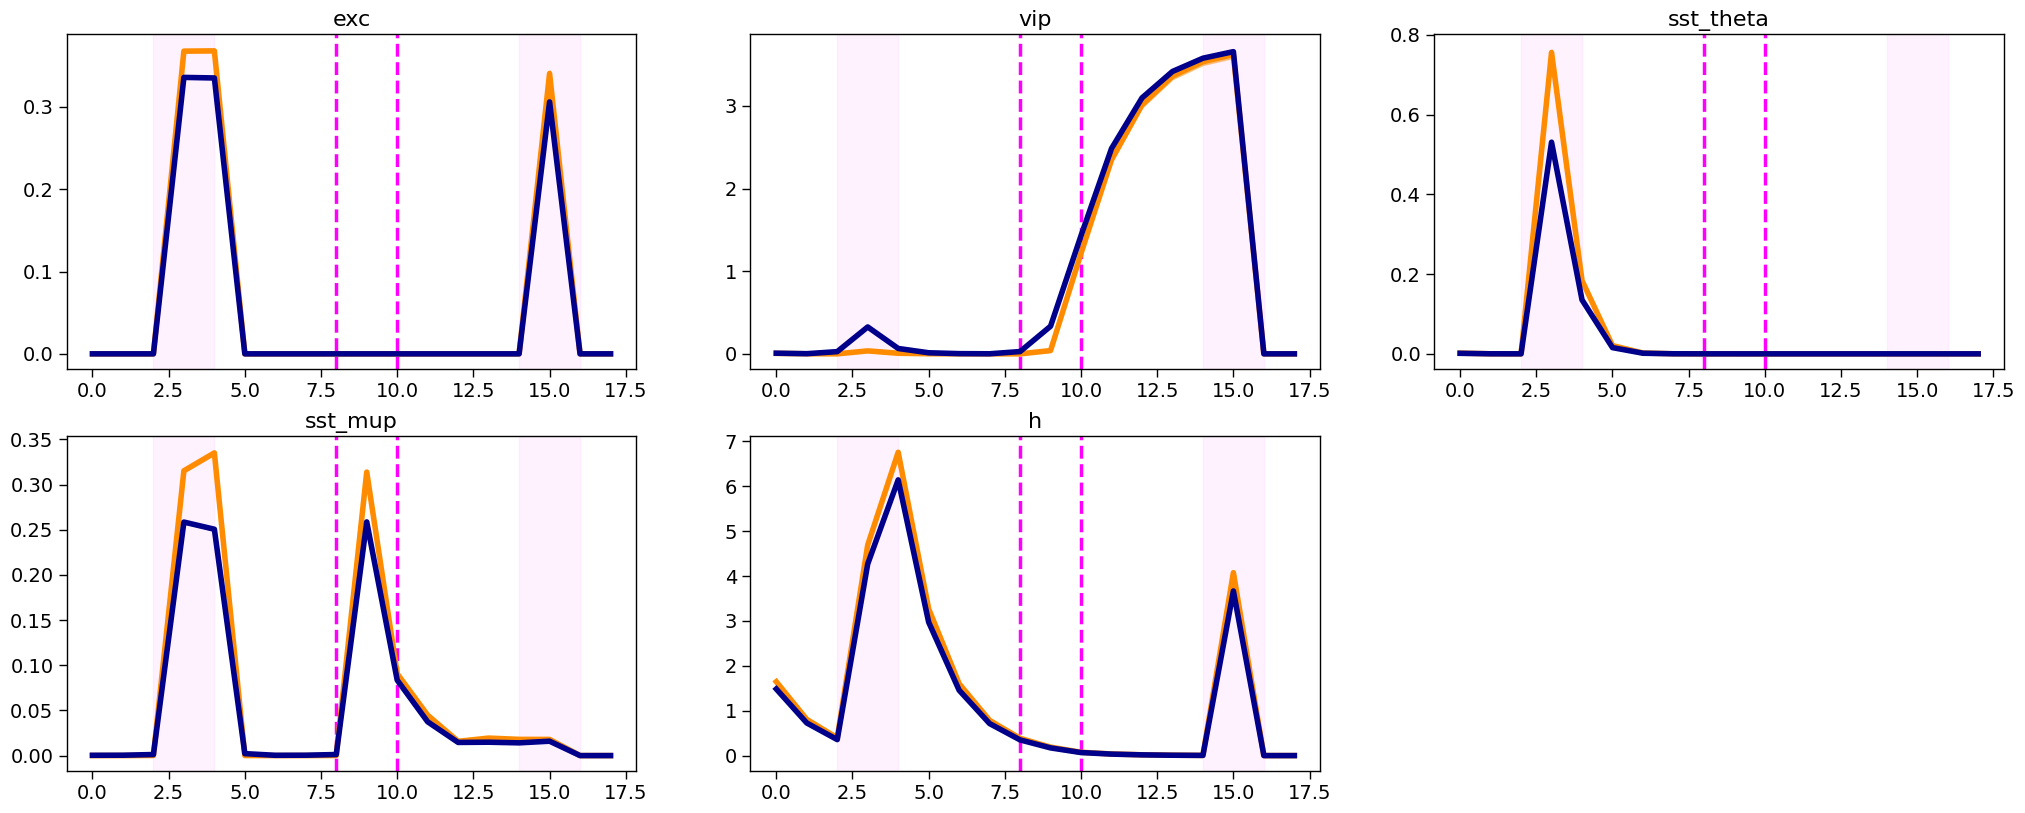

In [37]:
##### plot responses around omissions

with plt.style.context(['nature', 'notebook']):
    
    fig3 = plt.figure(figsize=(25, 20))
    plt.tight_layout(pad=10, h_pad=5)

    for i, pop in enumerate(omission_responses['familiar'].keys()):
        ax = plt.subplot(4, 3, i+1)
        plot_trial_responses(args, ax, omission_responses['familiar'][pop], omission_responses['novel'][pop], trial_mode='omission', normalize=False)
        _ = ax.set_title(f"{pop}")

### Perception with Action

In [38]:
args, change_responses, omission_responses = load_results_files(f"{SCRATCH}/novelty_encoding_model/results/perception_action", "perception_action")
args = Namespace(**args)

/scratch/2031461/ipykernel_57570/1890722279.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path, map_location='cpu')


/storage/home/hcoda1/2/asharafeldin3/code/cortical_circuit_model_for_novelty_encoding/utils/plotting.py:39: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(half_blank, half_blank + args.img_ts, color=pre_clr, alpha=0.25, edgecolor="none", linewidth=0, zorder=1)
/storage/home/hcoda1/2/asharafeldin3/code/cortical_circuit_model_for_novelty_encoding/utils/plotting.py:40: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(half_blank + args.blank_ts + args.img_ts, half_blank + args.blank_ts + 2 * args.img_ts, color=change_clr, alpha=0.25,


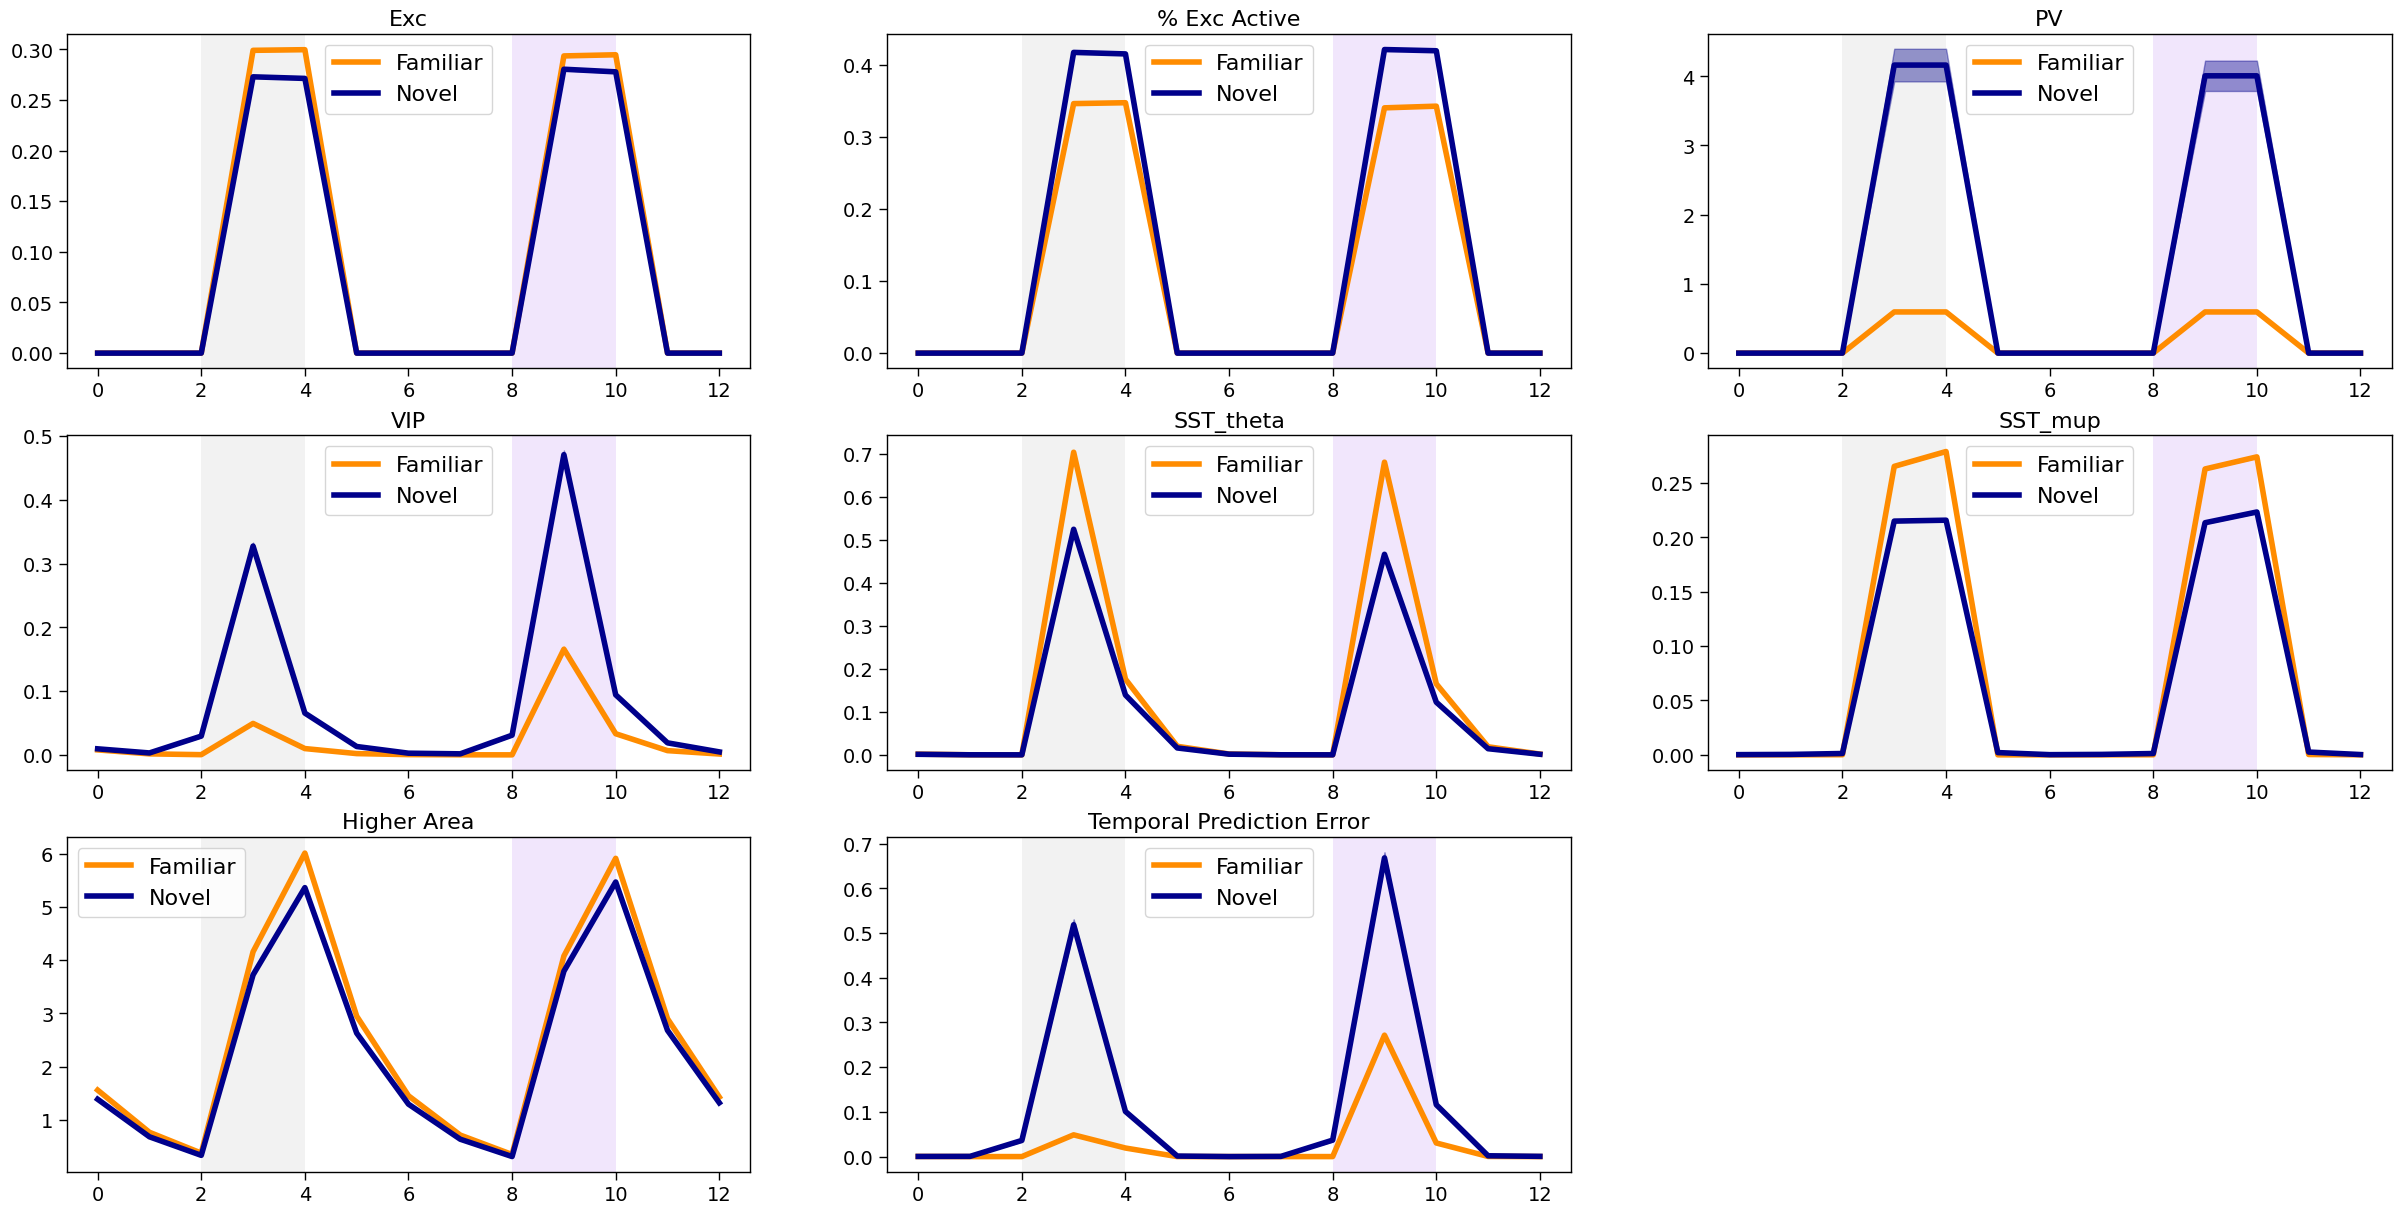

In [39]:
##### plot responses around image change

debug = False

include_pops = {'z': 'Exc', 'frac_active': '% Exc Active', 'sigma_q': 'PV', 'sigma_p': 'VIP',
                'theta': 'SST_theta', 'mu_p': 'SST_mup', 'h': 'Higher Area', 'temp_error': 'Temporal Prediction Error'}

crf = change_responses['familiar']
crn = change_responses['novel']

change_responses['familiar']['exp'] = (crf['theta_ff'] + torch.randn_like(crf['theta_ff'])) * torch.exp(-crf['vip_inh'])
change_responses['novel']['exp'] = (crn['theta_ff'] + torch.randn_like(crn['theta_ff'])) * torch.exp(-crn['vip_inh'])

with plt.style.context(['nature', 'notebook']):
    
    if debug:
        
        fig3 = plt.figure(figsize=(40, 20))
        plt.tight_layout(pad=10, h_pad=5)
        
        for i, pop in enumerate(change_responses['familiar'].keys()):
            ax = plt.subplot(8, 3, i+1)
            plot_trial_responses(args, ax, change_responses['familiar'][pop], change_responses['novel'][pop], normalize=False)
            ax.set_title(f"{pop}")
            ax.legend()
    else:
        
        fig3 = plt.figure(figsize=(30, 20))
        plt.tight_layout(pad=10, h_pad=5)
        
        for i, pop in enumerate(include_pops.keys()):
            ax = plt.subplot(4, 3, i+1)
            plot_trial_responses(args, ax, change_responses['familiar'][pop], change_responses['novel'][pop], normalize=False)
            ax.set_title(f"{include_pops[pop]}")
            ax.legend()

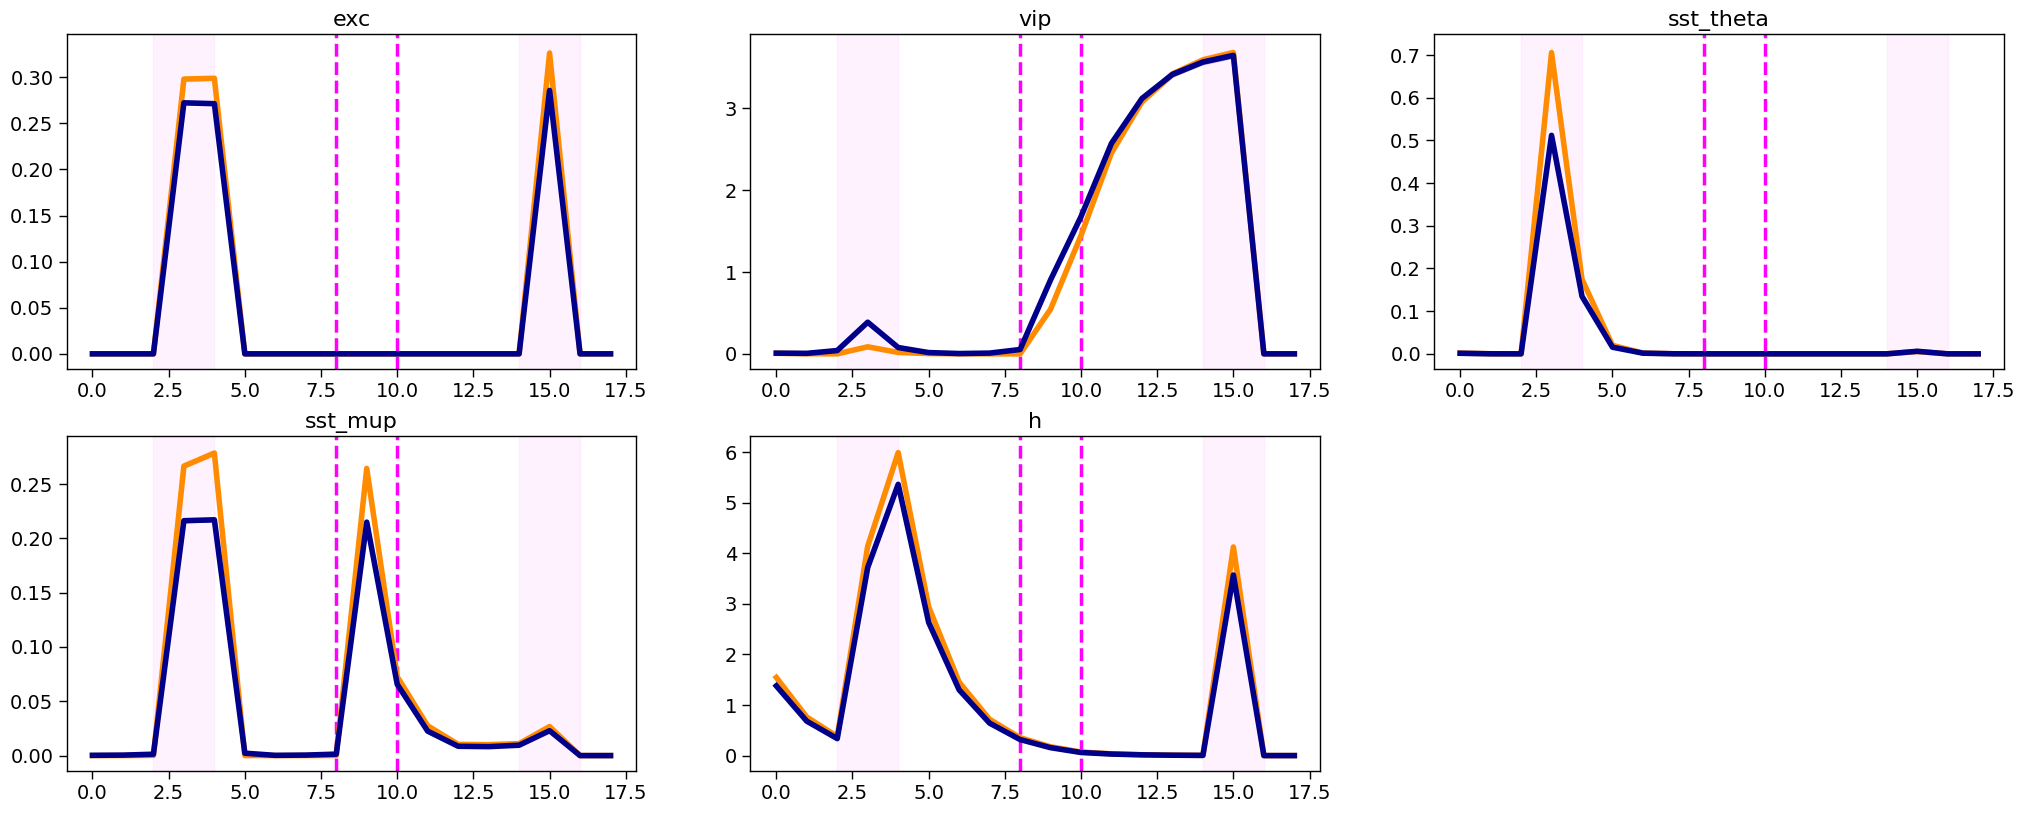

In [40]:
##### plot responses around omissions

with plt.style.context(['nature', 'notebook']):

    fig3 = plt.figure(figsize=(25, 20))
    plt.tight_layout(pad=10, h_pad=5)

    for i, pop in enumerate(omission_responses['familiar'].keys()):
        ax = plt.subplot(4, 3, i+1)
        plot_trial_responses(args, ax, omission_responses['familiar'][pop], omission_responses['novel'][pop], trial_mode='omission', normalize=False)
        _ = ax.set_title(f"{pop}")

## TODO

- Recreate the response plots using the experimental data to compare with our response plots
    - Use Kyle's code

- Visualize dprime during training to compare performance with experimental setting

- Response adaptation model with three populations (Exc, VIP, SST) and input weights taken from our model

- Fix normalization in omission responses (consider only pre-omission response for min/max calculation)
    - same for change responses (relative to change onset)

- Bar plots based on Kyle's model responses 

##### Paper figures

1. 
2.
3. 
4. 

torch.Size([64])


Text(0.5, 1.0, 'VIP (sigma_p)')

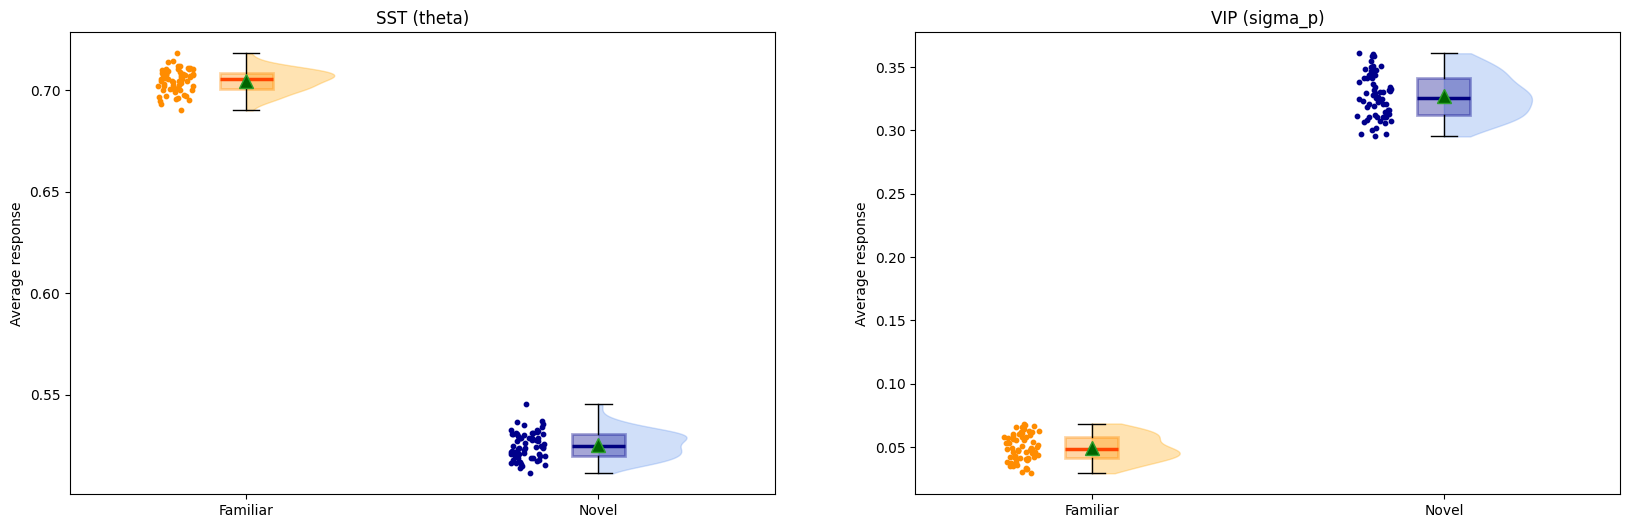

In [41]:
from utils.plotting import raincloud_plot

sq = 3

exp_ax1 = plt.subplot(1, 2, 1)
famt = change_responses['familiar']['theta'][:, 3].detach()
novt = change_responses['novel']['theta'][:, 3].detach()
nonlin = lambda x: x.mean(0) #torch.relu(x - .95).mean(0) #(1 - 0.1 * x).mean(-1) 
print(nonlin(novt).shape)
raincloud_plot(exp_ax1, nonlin(famt), nonlin(novt))
plt.title('SST (theta)')
#plt.ylim([0., 0.65])

exp_ax2 = plt.subplot(1, 2, 2)
fams = change_responses['familiar']['sigma_p'][:, 3].detach()
novs = change_responses['novel']['sigma_p'][:, 3].detach()
raincloud_plot(exp_ax2, torch.mean(fams, dim=0), torch.mean(novs, dim=0))
plt.title('VIP (sigma_p)')
#plt.ylim([0., 0.1])